In [28]:
import zipfile
import os
import datetime
import pickle
from tabulate import tabulate

import nlp_utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# NLP
import spacy
import nltk

import re
from collections import Counter
from unidecode import unidecode
from string import punctuation
from string import digits
punct_translator = str.maketrans('','', punctuation)
digit_translator = str.maketrans('', '', digits)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
nltk.download('vader_lexicon')

# INITIALIZATION
log_dir = "./logs/"
data_dir = "./data/"
results_dir = "./results/"

data_cases_dir = "cases/"
data_case_rev = "case_reversed.csv"

logger = nlp_utils.Logger(log_dir)
timer = nlp_utils.Timer("timer")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\roksi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
# LOAD DATA
load_data = True

if load_data:
    df_all = pd.read_pickle(results_dir + "task_1_all.pkl")
else:
    # CASES REVERSED
    df_case_rev = pd.read_csv(data_dir + data_case_rev)
    logger.append("case_reversed:\t" + str(df_case_rev.shape))
    logger.append("case_reversed columns:\t" + str([col for col in df_case_rev.columns]))

    data_cases = os.listdir(data_dir + data_cases_dir)
    logger.append("cases:\t" + str(len(data_cases)))

    # CASES CONTENT
    columns = ["caseid", "year", "content"]
    df_cases = pd.DataFrame(columns=columns)

    for idx, doc in enumerate(data_cases):
        year = doc.split("_")[0]
        case_id = doc.split("_")[1].split(".")[0]
    #     print(idx, doc, year, case_id)

        with open(data_dir + data_cases_dir + doc, "r", encoding="utf8") as file:  
            content = file.read() 

        df_cases.loc[idx] = {columns[0]: case_id, columns[1]: year, columns[2]: content}


    logger.append("cases:\t" + str(df_cases.shape))
    logger.append("cases columns:\t" + str([col for col in df_cases.columns]))

    # LINK DATAFRAMES
    print("" + str(sorted(set(df_case_rev["caseid"].values)) == sorted(set(df_cases["caseid"].values))))

    df_all = pd.concat([df_cases.sort_values(by="caseid").set_index('caseid'),
                        df_case_rev.sort_values(by="caseid").set_index('caseid')],
                        axis=1, join='inner').reset_index()

    df_all.to_pickle(results_dir + "task_1_all.pkl")

    
logger.append("df_all:\t" + str(df_all.shape))
logger.append("df_all columns:\t" + str([col for col in df_all.columns]))
df_all.sample(5)

df_all:	(5762, 4)
df_all columns:	['caseid', 'year', 'content', 'case_reversed']


,caseid,year,content,case_reversed
3791,X442FH,1945,"HOLMES , Circuit Judge.\nThis is an estate ta...",1
2595,X3T9UD,1969,"LEWIS R. MORGAN , Circuit Judge: The present ...",1
266,X1FFG9M003,2011,"W. FLETCHER, Circuit Judge: Northwest Environ...",1
685,X350VA,1997,"BRISCOE , Circuit Judge.\nPlaintiffs brought ...",0
242,X1CS4VM003,2010,"BEEZER, Circuit Judge: This case returns to u...",0


In [12]:
# TASK 1
load_data = True

if load_data:
    df_counts = pd.read_pickle(results_dir + "task_1_counts.pkl")
else:
    timer.__enter__()

    N_doc = 10000
    nlp = spacy.load("en", disable = ["tagger", "ner"])
    print(nlp.pipe_names)
    
    if N_doc >= df_all.shape[0]:
        N_doc = df_all.shape[0]
        
    counts_ = np.zeros((N_doc, len(["sentence", "word", "non-stop word","letter"])))

    for idx, row in df_all.iterrows():
        if idx % 5 == 0:
            print(idx, end="\r")
        if idx >= N_doc:
            break

        content = row["content"]
        caseid = row["caseid"]

        doc = nlp(unidecode(content))

        sentences = list(doc.sents)

        words = [token.text.lower() for token in doc if not token.is_punct and not token.is_space]
        words_nostop = [token.text.lower() for token in doc if not token.is_punct and not token.is_space and not token.is_stop]
        letters = "".join(words).translate(punct_translator).translate(digit_translator).replace("\n", "")

        counts_[idx, :] = np.array([len(sentences), len(words), len(words_nostop), len(letters)])
    
    df_counts = pd.concat([df_all.drop(["content", "case_reversed"], axis=1),
                    pd.DataFrame(counts_, columns = ["sentence", "word", "non-stop word","letter"])], axis=1)

    df_counts.to_pickle(results_dir + "task_1_counts.pkl")

    timer.__exit__()

Distributions of counts per token type


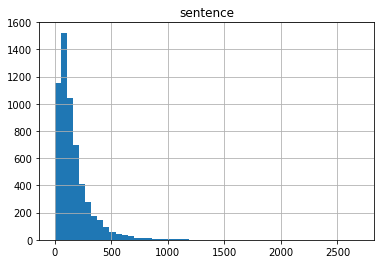

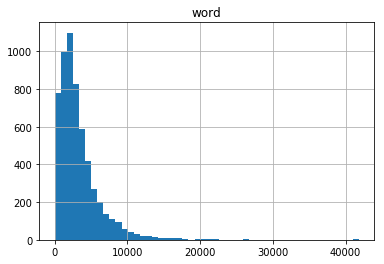

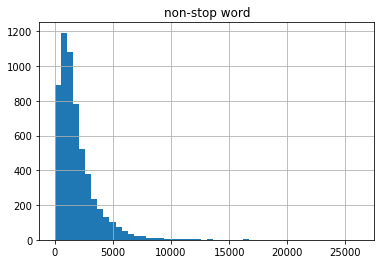

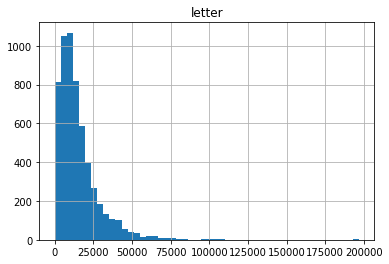

In [13]:
# TASK 1
logger.append("Distributions of counts per token type")

for idx, cat in enumerate(["sentence", "word", "non-stop word","letter"]):
    df_counts.hist(column=cat, bins=50)

In [14]:
# TASK 2
load_data = True

if load_data:
    df_pos = pd.read_pickle(results_dir + "task_2_pos_per_year.pkl")
else:
    timer.__enter__()

    nlp = spacy.load("en", disable = ["parser", "ner"])
    print(nlp.pipe_names)

    counts_pos = np.zeros((df_all.shape[0], len(["NOUN", "VERB", "ADJ"])))

    for idx, row in df_all.iterrows():
        if idx % 5 == 0:
            print(idx, end="\r")

        content = row["content"]
        caseid = row["caseid"]
        year = row["year"]

        doc = nlp(unidecode(content))

        pos = [token.pos_ for token in doc]

        pos_freq = Counter(pos)

        counts_pos[idx, :] = np.array([pos_freq["NOUN"], pos_freq["VERB"], pos_freq["ADJ"]])    


    df_pos = pd.concat([df_all.drop(["content", "case_reversed"], axis=1),
                        pd.DataFrame(counts_pos, columns = ["NOUN", "VERB", "ADJ"])], axis=1)

    df_pos.to_pickle(results_dir + "task_2_pos_per_year.pkl")

    timer.__exit__()

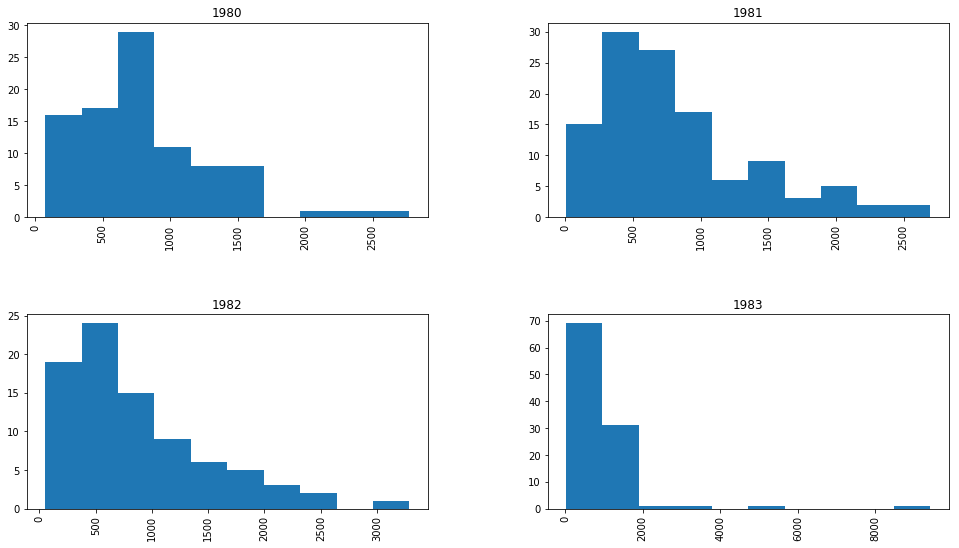

In [15]:
# TASK 2
tag = "NOUN"
year_span = (1980, 1983)

df_pos[(df_pos["year"].astype('int64') >= year_span[0]) & 
       (df_pos["year"].astype('int64') <= year_span[1])] \
        .hist(by="year", column = tag, figsize = (16, 9));

In [16]:
# TASK 3, 4
load_data = True

all_ngrams_counters = []

if load_data:
    with open(results_dir + "task_3_ngrams.pkl", "rb") as f:
        all_ngrams_counters = pickle.load(f)
else:
    timer.__enter__()
    N_doc = 6000

    if N_doc >= df_all.shape[0]:
        N_doc = df_all.shape[0]
    
    nlp = spacy.load("en", disable = ["ner", "parser"])
    print(nlp.pipe_names)
    
    for idx, content in enumerate(df_all["content"]):
        if idx % 5 == 0:
            print(idx, end="\r")

        doc = nlp(unidecode(content))

        norm_tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_space and not token.is_stop 
                        and not token.is_digit and len(token) > 2 and not (any(i.isdigit() for i in token.text))]
        
        pos = [token.pos_ for token in doc if not token.is_punct and not token.is_space and not token.is_stop 
                        and not token.is_digit and len(token) > 2 and not (any(i.isdigit() for i in token.text))]
        
        ngrams = list(nltk.ngrams(norm_tokens, 3))
        pos_ngrams = list(nltk.ngrams(pos, 3))
        
        ngrams_noun = ["-".join(ngram) for idx, ngram in enumerate(ngrams) if pos_ngrams[idx][2] == "NOUN"]
        all_ngrams_counters.append(Counter(ngrams_noun))      
            
        if idx == N_doc - 1:
            break

    with open(results_dir + "task_3_ngrams.pkl", "wb") as f:
        pickle.dump(all_ngrams_counters, f)

    timer.__exit__()

logger.append("All N-gram counters:\t" + str(len(all_ngrams_counters)))
logger.append("N-gram counter sample (most common 20):\t" + str(all_ngrams_counters[10].most_common(20)))

All N-gram counters:	5762
N-gram counter sample (most common 20):	[('net-emissions-increase', 7), ('hourly-rate-emissions', 7), ('income-tax-withholding', 7), ('change-change-method', 5), ('change-method-operation', 5), ('the-district-court', 4), ('modification-defined-section', 4), ('increase-hourly-rate', 4), ('identical-statutory-definitions', 4), ('air-quality-standards', 3), ('defined-section-source', 3), ('section-source-facility', 3), ('nsps-statutory-definition', 3), ('statutory-definition-modification', 3), ('significant-net-emissions', 3), ('increase-hours-operation', 3), ('precise-question-issue', 3), ('interpret-statutory-term', 3), ('rowan-u.s.-s.ct', 3), ('modification-psd-provisions', 3)]


In [17]:
# TASK 3, 4
load_data = False

if load_data:
#     X = np.load(results_dir + "task_4_X.npy")  
    
#     with open(results_dir + "task_4_most_freq_ngrams.pkl", "rb") as f:
#         most_freq_ngrams = pickle.load(f) 
        
    X = np.load(results_dir + "task_4_X_3000.npy")  
    
    with open(results_dir + "task_4_most_freq_ngrams_3000.pkl", "rb") as f:
        most_freq_ngrams = pickle.load(f) 
else:
    timer.__enter__()
        
    n_features = 3000
    X = np.zeros((len(all_ngrams_counters), n_features), dtype=np.int8)

    most_freq_ngrams = [ngram[0] for ngram in sum(all_ngrams_counters, Counter()).most_common(n_features)]

    logger.append("Most frequent n-gram found.")
    
    for idx, counter in enumerate(all_ngrams_counters):
        if idx % 5 == 0:
            print(idx, end="\r")
        X[idx, :] = np.array([counter[ngram] for ngram in most_freq_ngrams])

        
#     with open(results_dir + "task_4_most_freq_ngrams.pkl", "wb") as f:
#         pickle.dump(most_freq_ngrams, f) 

#     np.save(results_dir + "task_4_X.npy", X)
    
    with open(results_dir + "task_4_most_freq_ngrams_3000.pkl", "wb") as f:
        pickle.dump(most_freq_ngrams, f) 

    np.save(results_dir + "task_4_X_3000.npy", X)
    
    timer.__exit__()
    
logger.append("20 most frequent N-grams in the corpus:\t" + str(most_freq_ngrams[0:20]))
logger.append("N-gram counts in i-th document (only first 20 counts are printed), i.e. X[i, :] = \t" + str(X[10, 0:20]))
logger.append("Debbugging check (descending counts, feature in first column is most frequent):\t" + str(X.sum(axis=0)))

Most frequent n-gram found.
[timer]
Elapsed: 6111.393949985504
20 most frequent N-grams in the corpus:	['u.s.-s.ct-l.ed', 'the-district-court', 'denied-u.s.-s.ct', 'states-u.s.-s.ct', 'co.-u.s.-s.ct', 'judgment-district-court', 'the-trial-court', 'collective-bargaining-agreement', 'subject-matter-jurisdiction', 'internal-quotation-marks', 'writ-habeas-corpus', 'motion-summary-judgment', 'district-court-order', 'supreme-court-decision', 'district-court-decision', 'inc.-u.s.-s.ct', 'affirm-district-court', 'unfair-labor-practice', 'supra-u.s.-s.ct', 'judge-this-appeal']
N-gram counts in i-th document (only first 20 counts are printed), i.e. X[i, :] = 	[0 4 0 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
Debbugging check (descending counts, feature in first column is most frequent):	[7055 7049 2645 ...   22   22   22]


In [18]:
X.shape

(5762, 3000)

In [19]:
# TASK 3, 4
# TRAIN-TEST SPLIT
# CONSTRUCT 
y = df_all["case_reversed"].values
logger.append("X:\t" + str(X.shape))
logger.append("y:\t" + str(y.shape))

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, y, df_all["caseid"], test_size=0.1, 
                                                                       shuffle=True, random_state=42)

# print(X_train.shape, y_train.shape, id_train.shape, X_test.shape, y_test.shape, id_test.shape)

# SAVE TO CSV
h = ["f" + str(i) for i in range(0, X.shape[1])]

nlp_utils.save_csv(y_train, "y_train", ["case_reversed"], "id", id_train, "./data/")
nlp_utils.save_csv(y_test, "y_test", ["case_reversed"], "id", id_test, "./data/")

nlp_utils.save_csv(X_train, "X_train", h, "id", id_train, "./data/")
nlp_utils.save_csv(X_test, "X_test", h, "id", id_test, "./data/")

X:	(5762, 3000)
y:	(5762,)
./data/ y_train created
./data/ y_test created
./data/ X_train created
./data/ X_test created


In [32]:
# TASK 5, 6
def train(X_train_file= "./data/X_train.csv",
          X_test_file = "./data/X_test.csv",
          y_train_file = "./data/y_train.csv",
          y_test_file = "./data/y_test.csv",
          impute = (False, ),
          scaling = (False, True),
          power_scaling = False,
          random_search = (False, ),
          training = (True, ),
          cross_validation = (False, ),
          output = False
          ):

    logger.set_params([X_test_file, X_train_file, y_train_file, y_test_file, impute, scaling, power_scaling, random_search, training, cross_validation, output])
    # ---------------------------------------------------------------------------------------------------------------- #
    # Helpers
    
    def load_data():
        
        X_train = nlp_utils.load_csv_to_numpy(X_train_file, id_h="id")
        X_test = nlp_utils.load_csv_to_numpy(X_test_file, id_h="id")

        y_train = nlp_utils.load_csv_to_numpy(y_train_file, id_h="id")
        y_test = nlp_utils.load_csv_to_numpy(y_test_file, id_h="id")
        
        logger.append("X_train:\t" + str(X_train.shape))
        logger.append("y_train:\t" + str(y_train.shape))
        logger.append("X_test:\t" + str(X_test.shape))
        logger.append("y_test:\t" + str(y_test.shape))
        
        return X_train, y_train, X_test, y_test

    def class_labels(y):
        labels = np.unique(y)
        count = [np.count_nonzero(y == c) for c in labels]
        weights = [c / sum(count) for c in count]
        
        logger.append("Class labels:\t" + str(labels))
        logger.append("Class count:\t" + str(count))
        logger.append("Class weights:\t" + str(weights))
        
        return labels, count, weights

    # ---------------------------------------------------------------------------------------------------------------- #
    # Load data
    X_train, y_train, X_test, y_test = load_data()
    
    logger.append("Training class labels.")
    class_labels, class_count, class_weights = class_labels(y_train)

    logger.append("Data loaded.")

    # ---------------------------------------------------------------------------------------------------------------- #
    # Missing values
    if impute[0]:
        imp = SimpleImputer(missing_values=np.nan, strategy=impute[1])
        imp = imp.fit(X_train)
        X_train = imp.transform(X_train)
        X_test = imp.transform(X_test)
        logger.append("Missing values imputed.")

    # ---------------------------------------------------------------------------------------------------------------- #
    # Feature scaling
    if scaling[0]:
        scaler = StandardScaler(with_mean=scaling[1])
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        logger.append("Scaled.")

    if power_scaling:
        ptransformer = PowerTransformer()
        ptransformer.fit(X_train)
        X_train = ptransformer.transform(X_train)
        X_test = ptransformer.transform(X_test)
        logger.append("Power scaled.")

    # ---------------------------------------------------------------------------------------------------------------- #
    # Training

    if random_search[0]:
        logger.append("Grid search started.")
        cls = random_search[1]["cls"]
        rs = GridSearchCV(cls, param_grid=random_search[1]["param_dist"], 
                          cv=5, n_jobs=-1, scoring="f1")
        rs.fit(X_train, y_train.ravel())
        best_est = rs.best_estimator_
        logger.append(rs.best_estimator_)
        logger.append("Grid search finished.")
            
    if training[0]:
        if not random_search[0]:
            est = random_search[3]
        else:
            est = best_est

        vc = est

        logger.append("Training started.")
        vc.fit(X_train, y_train.ravel())
        logger.append("Training finished.")

        logger.append("Prediction started.")
        y_train_pred = vc.predict(X_train)
        y_test_pred = vc.predict(X_test)
        logger.append("Prediction finished.")
        
        scores = [
            ["Accuracy", accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
            ["F1", f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)],
            ["Recall", recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
            ["Precision", precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)]
            ]
        
        # print(tabulate([scores, headers=["Training set", "Test set"])
        logger.append(tabulate(scores, headers=["Training set", "Test set"]))
        
    # ------------------------------------------------------------------------------------------------------------ #
    # Cross validation
    if cross_validation[0]:
        logger.append("Crossvalidation started.")
        score = cross_val_score(vc, X_train, y_train.ravel(), cv=cross_validation[1], scoring=cross_validation[2], n_jobs=-1)
        logger.append("Mean:\t%f\t\tStd:\t%f\t-\t%s" % (score.mean(), score.std(), cross_validation[2]))
        
        score = cross_val_score(vc, X_train, y_train.ravel(), cv=cross_validation[1], scoring=cross_validation[3], n_jobs=-1)
        logger.append("Mean:\t%f\t\tStd:\t%f\t-\t%s" % (score.mean(), score.std(), cross_validation[3]))
        
        logger.append("Crossvalidation finished.")

    # ---------------------------------------------------------------------------------------------------------------- #

    logger.create_log()
    return vc

In [34]:
# TASK 5, 6
param_dist = {
    "param_dist": {
        "penalty": ["l1", "l2"],
        "C": [np.power(10.0, c) for c in range(-7, -3)]
    },
    "cls": LogisticRegression(random_state=0, solver='liblinear', 
                              n_jobs=-1, verbose=1, max_iter=100, class_weight ="balanced")
}


# Better if equal cost for both classes: class_weight !="balanced", approx. F1 = 0.65

best_est = LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=50,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=1, warm_start=False)

estimator = train(
      scaling = (True, False),
      power_scaling = False,
      random_search = (True, param_dist, 10, best_est),
      training = (True, param_dist),
      cross_validation = (True, 10, "accuracy", "f1"),
      output = False
      )

./data/X_test.csv
./data/X_train.csv
./data/y_train.csv
./data/y_test.csv
(False,)
(True, False)
False
(True, {'param_dist': {'penalty': ['l1', 'l2'], 'C': [1e-07, 1e-06, 1e-05, 0.0001]}, 'cls': LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=1, warm_start=False)}, 10, LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=50,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=1, warm_start=False))
(True, {'param_dist': {'penalty': ['l1', 'l2'], 'C': [1e-07, 1e-06, 1e-05, 0.0001]}, 'cls': LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=

,caseid,year,content,case_reversed,predict
3455,X420MK,1963,"JERTBERG , Circuit Judge.\nThis is an appeal ...",1,1
1217,X3FLHT,2000,"OPINION HOLSCHUH , District Judge.\nPlaintiff...",0,1
344,X1JIM48003,2013,"WALLACH, Circuit Judge.\nOpinion for the cour...",1,1
5273,XABD86,1979,"ELY , Circuit Judge: These appeals stem from ...",1,1
4248,X46J0I,1937,"DAVIS , Circuit Judge.\nWhen this case was he...",0,0
4276,X46NQ9,1938,"WILBUR , Circuit Judge.\nThis action was brou...",0,0
5474,XABQFF,1985,"IRVING R. KAUFMAN , Circuit Judge: Fascinated...",0,1
4272,X46NIM,1938,"WOODROUGH , Circuit Judge.\nThis appeal is ta...",0,0
2794,X3U87K,1977,"EUGENE A. WRIGHT , Circuit Judge: On this app...",1,1
4270,X46NGO,1938,"LINDLEY , District Judge.\nPlaintiff appeals ...",0,0


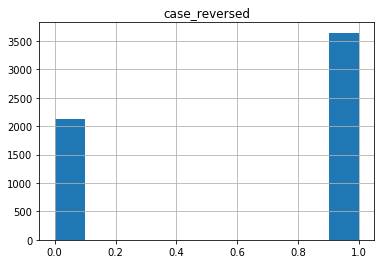

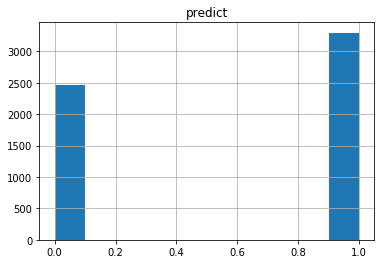

In [35]:
# Prediction distributions
df_all.hist(column="case_reversed")
pd.DataFrame(estimator.predict(X), columns=["predict"]).hist(column="predict")

pd.concat([df_all, pd.DataFrame(estimator.predict(X), columns=["predict"])], axis=1).sample(10, random_state=10)

In [38]:
# TASK 7
load_data = True
N_doc = 50

if load_data:
    df_sents = pd.read_pickle(results_dir + "task_7_sentences.pkl")
else:
    timer.__enter__()
    
    if N_doc >= df_all.shape[0]:
        N_doc = df_all.shape[0]
        
    sentences = []

    rand_idx = np.random.randint(0, df_all.shape[0], size=N_doc)
    
    for idx, row in df_all.iterrows():
        if idx % 5 == 0:
            print(idx, end="\r")
        if idx not in rand_idx:
            pass
            
        caseid = row["caseid"]
        content = unidecode(row["content"])

        sentences.extend(nlp_utils.tokenize_sentence(content, caseid, package="spacy"))

    df_sents = pd.DataFrame(sentences)
    df_sents.to_pickle(results_dir + "task_7_sentences.pkl")
    
    timer.__exit__()
    
logger.append("df_sents:\t" + str(df_sents.shape))

df_sents:	(12982, 2)


In [39]:
# TASK 7
load_data = False

if load_data:
    df_sents_vader = pd.read_pickle(results_dir + "task_7_vader.pkl")
else:
    timer.__enter__()
    
    sia = SentimentIntensityAnalyzer()
    vader_analysis = []
    
    for idx, sent in df_sents.iterrows():
        if idx % 10 == 0:
            print(str(idx / df_sents.shape[0] * 100)[0:4] + " %", end="\r")

        sent_score = sia.polarity_scores(sent["sentence"])
        vader_analysis.append(sent_score)

    df_sents_vader = pd.concat((df_sents, pd.DataFrame(vader_analysis)), axis=1, ignore_index=False, sort=False)
    
    df_sents_vader.to_pickle(results_dir + "task_7_vader.pkl")
    
    timer.__exit__()
    
sentiment = "compound"

for _, row in df_sents_vader.sort_values(by=sentiment, ascending=False).head(10).iterrows():
    print(str(row[sentiment]) + ":\t" + row["sentence"])

print("\n")

for _, row in df_sents_vader.sort_values(by=sentiment, ascending=True).head(10).iterrows():
    print(str(row[sentiment]) + ":\t" + row["sentence"])

[timer]
Elapsed: 18.046592473983765
0.9859:	In making its Attorney's Fee Ruling, the district court was obliged, pursuant to our decision in Johannssen, to consider each of five factors: () the degree of the opposing party's culpability or bad faith; () the ability of the opposing party to satisfy an award of attorney's fees; () whether an award of attorney's fees against the opposing party would deter other persons acting under similar circumstances; () whether the party requesting attorney's fees sought to benefit all participants and beneficiaries of an ERISA plan or to resolve a significant legal question regarding ERISA itself; and () the relative merits of the parties' positions.
0.9623:	A party is "necessary" if "() in [its] absence complete relief cannot be afforded among those already parties, or () [it] claims an interest relating to the subject of the action and is so situated that the disposition of the action in [its] absence may (i) as a practical matter impair or impede 

In [40]:
# TASK 8
tfidf = TfidfVectorizer(min_df=0.01, max_df=0.9, 
                        max_features=1000, stop_words="english", 
                        use_idf=True, ngram_range=(1,1))

X_tfidf = tfidf.fit_transform(df_sents["sentence"])

logger.append("X_tfidf:\t" + str(X_tfidf.shape))

X_tfidf:	(12982, 123)


In [41]:
# TASK 8
cos_sim = cosine_similarity(X_tfidf, X_tfidf) - np.eye(X_tfidf.shape[0]) 

for idx in np.random.randint(0, X_tfidf.shape[0], 10):
    idx_max = np.argmax(cos_sim[idx, :])
    idx_min = np.argmin(cos_sim[idx, :])

    sent = df_sents["sentence"].loc[idx]
    sent_max = df_sents["sentence"].loc[idx_max]
    sent_min = df_sents["sentence"].loc[idx_min]
    
    logger.append(sent)
    logger.append("\n")
    logger.append("max_similarity:\t" + str(cos_sim[idx, idx_max])[0:4] + "\t" + sent_max)
    logger.append("min_similarity:\t" + str(cos_sim[idx, idx_min])[0:4] + "\t" + sent_min)
    
    logger.append(120 * "-")

Thus, the question comes down to whether a school may, in the absence of concern about disruption of educational activities, punish and censor non-disruptive, off-campus speech by students during school-authorized activities because the speech promotes a social message contrary to the one favored by the school.


max_similarity:	0.94	Accordingly, we must move to the question of whether the restriction on such non-commercial speech is constitutionally overbroad.
min_similarity:	0.0	BECKER, Circuit Judge.
------------------------------------------------------------------------------------------------------------------------
Our . "discretionary ...


max_similarity:	0.0	BECKER, Circuit Judge.
min_similarity:	-1.0	Our . "discretionary ...
------------------------------------------------------------------------------------------------------------------------
Finally, we vacate the district court's determination that PACE lacks standing, grant PACE's request for leave to amend its complaint

In [44]:
# TASK 9
num_clusters = 20

k_means = KMeans(random_state=0, n_clusters=num_clusters, n_jobs=-1, init="k-means++", verbose=0)
k_means.fit(X_tfidf)

df_sents["cluster"] = k_means.labels_.tolist()

for i in range(num_clusters):
    print("c = " + str(i + 1))
    for _, row in df_sents[df_sents["cluster"] == i].sample(5, random_state=0).iterrows():
        print(row["caseid"] + ":\t" + row["sentence"])    
        
    print("\n")

c = 1
X10LQ80003:	For the purpose of all of these contribution limits, a political party's state, county, and local branches (and national and regional affiliates of the party) count as a single unit.
X10LQ80003:	For example, the state committee brought suit on behalf of all of the town and county committees without ever consulting them or asking them to approve the lawsuit.
X12MV52003:	FWS staff had earlier suggested the development of a formal memorandum of understanding with ADEQ or the Arizona State Lands Department, but did not mention the Game and Fish Department.
X10LQ80003:	Subject to the applicable limits imposed by the statute, the mayoral candidates raised funds comparable to the amounts spent in State Senate races in the past.
X12MV52003:	Rather, the EPA will " encourage the State ...


c = 2
X13DQR8003:	The district court held that because PACE's complaint failed to state claims under ERISA , , - , or for improper termination by Crown, and because the issue in this action 

X118VF6003:	The district court stated accordingly that [b]ased on the language contained in this Tenth Circuit, and given the history of the law in this area, I am unable to conclude that the removal was improper ab initio....
X13JKD0003:	WILSON, Circuit Judge:
X12LENK003:	See Hernandez-Avalos, F.d at n. ("If a circuit court's interpretation of `aggravated felony' is different from the BIA's interpretation, the INS is bound by the decisions of the circuit court in removal proceedings arising in that circuit."); Yanez-Garcia, I. & N. Dec. , - .


c = 20
X12HNRQ003:	This appeal followed.
X13A5J0003:	The appeal of this type of agreement is certainty for the issuer: "The underwriting investment banker agrees that on a fixed date the corporation will receive a fixed sum for a fixed amount of its securities."
X12ALCO003:	Instead, it seeks to appeal from the portion of the district court's order that grants preliminary injunctive relief against the co-defendant Bank.
X12NKJQ003:	Lawrence oppo

In [1]:
# HELPER FUNCTIONS

In [29]:
# SPACY PIPELINES

# nlp = spacy.load("en", disable = ["tagger", "ner", "vectors", "textcat", "DependencyParser", 'similarity'
#                                  'merge_noun_chunks', 'merge_entities', 'tensorizer'])

# nlp = spacy.blank("en")
# nlp.add_pipe(nlp.create_pipe("parser"))

# nlp = spacy.load("en", disable = ["tagger", "ner"])
# print(nlp.pipe_names)

In [ ]:
# NLP
text = df_all.loc[0]["content"]
doc_id = df_all.loc[0]["caseid"]

doc = nlp(unidecode(text))

sentences = list(doc.sents)
tokens = list(doc)
words = [token.text.lower() for token in doc if not token.is_punct and not token.is_space]
words_nostop = [token.text.lower() for token in doc if not token.is_punct and not token.is_space and not token.is_stop]
pos = [token.pos_ for token in doc if not token.is_punct and not token.is_space and 
       (token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ == "VERB")]

word_freq = Counter(words)
word_nostop_freq = Counter(words_nostop)
pos_freq = Counter(pos)

logger.append("Document id (case id):\t" + str(doc_id))
logger.append("Number of sentences in document:\t" + str(len(sentences)))
logger.append("Number of tokens in document:\t" + str(len(tokens)))
logger.append("Number of words in document:\t" + str(len(words)))
logger.append("Number of non-stop words in document:\t" + str(len(words_nostop)))
logger.append("Most common words and their frequencies:\t" + str([pair for pair in word_freq.most_common(5)]))
logger.append("Most common non-stop words and their frequencies:\t" + str([pair for pair in word_nostop_freq.most_common(5)]))
logger.append("Pos tags:\t" + str(pos_freq.most_common()))

In [ ]:
text = df_all.loc[0]["content"]
doc_id = df_all.loc[0]["caseid"]

doc = nlp(text.lower())

words = [token.text for token in doc if not token.is_punct and not token.is_space and not token.is_stop 
         and not token.is_digit and len(token) > 2 and not (any(i.isdigit() for i in token.text))]

lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space and not token.is_stop 
          and not token.is_digit and len(token) > 2 and not (any(i.isdigit() for i in token.text))]

pos = [token.pos_ for token in doc if not token.is_punct and not token.is_space and not token.is_stop 
         and not token.is_digit and len(token) > 2 and not (any(i.isdigit() for i in token.text))]

vocabulary = sorted(set(lemmas))

logger.append("Words (no numbers, stop words, punctuation, spaces, size > 2):\t" + str(len(words)))
logger.append("Lemmas (no numbers, stop words, punctuation, spaces, size > 2):\t" + str(len(lemmas)))
logger.append("Vocabulary size (distinct words):\t" + str(len(vocabulary)))

ngrams = list(nltk.ngrams(words, 3))
pos_ngrams = list(nltk.ngrams(pos, 3))

ngrams_noun = [ngram for idx, ngram in enumerate(ngrams) if pos_ngrams[idx][2] == "NOUN"]

In [9]:
# TASK 3, 4 - STEMMING VERSION (NOT WORKING)
load_data = False

all_ngrams_counters = []

if load_data:
    with open(results_dir + "task_3_ngrams_stemming.pkl", "rb") as f:
        all_ngrams_counters = pickle.load(f)
else:
    timer.__enter__()
    N_doc = 1
    
    stemmer = PorterStemmer()

    if N_doc >= df_all.shape[0]:
        N_doc = df_all.shape[0]
    
    nlp = spacy.load("en", disable = ["ner", "parser"])
    print(nlp.pipe_names)
    
    for idx, content in enumerate(df_all["content"]):
        if idx % 5 == 0:
            print(idx, end="\r")

        doc = nlp(unidecode(content))

        norm_tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_space and not token.is_stop 
                        and not token.is_digit and len(token) > 2 and not (any(i.isdigit() for i in token.text))]
        
        pos = [token.pos_ for token in doc if not token.is_punct and not token.is_space and not token.is_stop 
                        and not token.is_digit and len(token) > 2 and not (any(i.isdigit() for i in token.text))]
        
        ngrams = list(nltk.ngrams(norm_tokens, 3))
        pos_ngrams = list(nltk.ngrams(pos, 3))
        
        print(ngrams)
        print([stemmer.stem(" ".join(ngram)) for ngram in ngrams])
        
        ngrams_noun = ["-".join(ngram) for idx, ngram in enumerate(ngrams) if pos_ngrams[idx][2] == "NOUN"]
        all_ngrams_counters.append(Counter(ngrams_noun))      
            
        if idx == N_doc - 1:
            break

    with open(results_dir + "task_3_ngrams_stemming.pkl", "wb") as f:
        pickle.dump(all_ngrams_counters, f)

    timer.__exit__()

logger.append("All N-gram counters:\t" + str(len(all_ngrams_counters)))
logger.append("N-gram counter sample (most common 20):\t" + str(all_ngrams_counters[10].most_common(20)))

['tagger']
[('becker', 'circuit', 'judge'), ('circuit', 'judge', 'this'), ('judge', 'this', 'petition'), ('this', 'petition', 'review'), ('petition', 'review', 'may'), ('review', 'may', 'final'), ('may', 'final', 'order'), ('final', 'order', 'occupational'), ('order', 'occupational', 'safety'), ('occupational', 'safety', 'health'), ('safety', 'health', 'review'), ('health', 'review', 'commission'), ('review', 'commission', 'dismissing'), ('commission', 'dismissing', 'notice'), ('dismissing', 'notice', 'contest'), ('notice', 'contest', 'affirming'), ('contest', 'affirming', 'citation'), ('affirming', 'citation', 'assessing'), ('citation', 'assessing', 'penalty'), ('assessing', 'penalty', 'occupational'), ('penalty', 'occupational', 'safety'), ('occupational', 'safety', 'health'), ('safety', 'health', 'act'), ('health', 'act', 'u.s.c.'), ('act', 'u.s.c.', 'supp'), ('u.s.c.', 'supp', 'the'), ('supp', 'the', 'question'), ('the', 'question', 'appeal'), ('question', 'appeal', 'commission'), 

['becker circuit judg', 'circuit judge thi', 'judge this petit', 'this petition review', 'petition review may', 'review may fin', 'may final ord', 'final order occup', 'order occupational safeti', 'occupational safety health', 'safety health review', 'health review commiss', 'review commission dismiss', 'commission dismissing notic', 'dismissing notice contest', 'notice contest affirm', 'contest affirming cit', 'affirming citation assess', 'citation assessing penalti', 'assessing penalty occup', 'penalty occupational safeti', 'occupational safety health', 'safety health act', 'health act u.s.c.', 'act u.s.c. supp', 'u.s.c. supp th', 'supp the quest', 'the question app', 'question appeal commiss', 'appeal commission abus', 'commission abused discret', 'abused discretion dismiss', 'discretion dismissing employ', 'dismissing employer notic', 'employer notice contest', 'notice contest occup', 'contest occupational safeti', 'occupational safety health', 'safety health act', 'health act enfo


[timer]
Elapsed: 0.4603419303894043
All N-gram counters:	1


IndexError: list index out of range